[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/git-sunao/path-integral/blob/main/test4.ipynb)

In [1]:
# jax
import jax
import jax.numpy as jnp
from jax import jit
from jax import grad
from jax import vmap
from jax import jacobian
from jax import jacfwd, jacrev
from jax import vjp
from jax.lax import scan
# plotting
import matplotlib.pyplot as plt
# numpyro
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

/Users/sugiyamasunao/miniconda3/envs/pyplint/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Run this if in Google Colab
# !git clone https://github.com/git-sunao/path-integral.git
# %cd path-integral
# !pip install -r requirements.txt

## Development notebook 4

$\providecommand{\d}{\mathrm{d}}$

### Example problem 4
Now we extend the development to more higher dimension $n$.

$$
Z = \int_{-\infty}^\infty \d x e^{i\sum_i x_i^2} = [(1+i)\sqrt{\pi/2}]^n = \pi^{n/2}e^{in\pi/2}
$$

We use the same idea as in the previous notebook: deforming the integration domain.

$$
Z = \int_{-\infty}^\infty \d x \frac{\partial z}{\partial x} e^{i\phi}
$$

This is too hard to perform for $n\geq3$ if we reply on the grid approach on $x_i$. Instead we use the Monte-Carlo approach.

We define $P(x) = \mathcal{N}|Je^{h}|$, where $\mathcal{N}$ is some constant normalization so that $P(x)$ can be a probability distribution. More concretely, $1=\mathcal{N}\int\d x |Je^{h}|$.
Then the partition function is 

$$
Z = \frac{1}{\mathcal{N}}\int\d x \mathcal{N} |Je^{h}| e^{iH+i\varphi_J}
$$

where $\varphi_J$ is the phase of the jacobian, $J=|J|e^{i\varphi_J}$.

In [3]:
def action_iphi(z):
    z2 = jnp.sum(z**2)
    iphi = 1j*z2
    # iphi = 1j*(z2/2 + 2/(1+z2))
    return iphi

def action_h(z):
    s = action_iphi(z)
    h = jnp.real(s) + 0.0j
    return h

def action_Seff(z):
    seff = -action_iphi(z)
    return seff

def integrand(z):
    return jnp.exp(action_iphi(z))

# # corresponding gradients
grad_iphi = grad(action_iphi, holomorphic=True)
grad_h    = grad(action_h, holomorphic=True)
grad_Seff = grad(action_Seff, holomorphic=True)

In [4]:
def flow_step(z, ds, thre=0.1):
    dSdz = grad_Seff(z)
    z = z + ds*jnp.conj(dSdz)
    return z

def flow_n_steps(x, ds, n_step):
    z = x.astype(complex)
    fnc = lambda z, null: (flow_step(z, ds), null)
    z, null = scan(fnc, z, length=n_step)
    return z

def flow_n_steps_with_jac(x, ds, n_step):
    z = flow_n_steps(x, ds, n_step)
    # Jacobian (we do this because the func is complex)
    def split(x, ds, n_step):
        f = flow_n_steps(x, ds, n_step)
        return jnp.real(f), jnp.imag(f)
    j = jacobian(split, argnums=0)(x, ds, n_step)
    j = j[0] + j[1]*1j
    j = jnp.linalg.det(j)

    return z, j

vflow = vmap(flow_n_steps_with_jac, (0,None,None), 0)

In [14]:
def model():
    # Define a prior for `x`
    x = []
    for i in range(ndim):
        xi = numpyro.sample('x{}'.format(i+1), dist.Uniform(-3, 3))
        x.append(xi)
    x = jnp.array(x)

    # flow
    # n_step in flow should be optimized depending on the dimension...
    z_pl, j = flow_n_steps_with_jac(x, 1e-3, 400)
    i = integrand(z_pl)

    amplt = jnp.abs(i*j)
    phase = i*j/amplt

    # likelihood
    numpyro.factor('loglike', jnp.log(amplt))

    # save derived parameters
    numpyro.deterministic('phase'    , phase)
    numpyro.deterministic('amplitude', amplt)


In [15]:
%%time
ndim = 8*3 + 1
# Set up and run the HMC sampler
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=20000)
mcmc.run(jax.random.PRNGKey(0))

# Get samples
samples = mcmc.get_samples()

sample: 100%|██████████| 20500/20500 [01:50<00:00, 185.75it/s, 7 steps of size 5.08e-01. acc. prob=0.90]


CPU times: user 1min 45s, sys: 3.8 s, total: 1min 49s
Wall time: 1min 58s


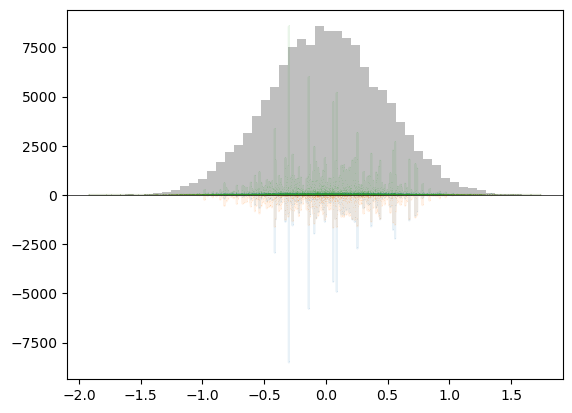

In [16]:
args = jnp.argsort(samples['x1'])
x = samples['x1'][args]
a = samples['amplitude'][args]
p = samples['phase'][args]

fig, ax = plt.subplots(1,1)
ax.plot(x, jnp.real(a*p), label='real', marker=',', alpha=0.1)
ax.plot(x, jnp.imag(a*p), label='imag', marker=',', alpha=0.1)
ax.plot(x, jnp.abs(a*p), label='abs', marker=',', alpha=0.1)
ax.axhline(0, color='black', linewidth=0.5)
h, b = jnp.histogram(samples['x1'], bins=50); h*= a.max()/h.max()
plt.bar(0.5*(b[:-1]+b[1:]), h, width=b[1] - b[0], align='center', alpha=0.5, color='gray')
plt.show()

In [18]:
Z_pl = jnp.mean(samples['phase'])
Z_ana= ((1+1j)*jnp.sqrt(jnp.pi/2))**ndim
print(f"PL : {Z_pl}")
print(f"Ana: {Z_ana}")
print('--phase--')
print(f"PL : {Z_pl.real/Z_pl.imag} ")
print(f"Ana: {Z_ana.real/Z_ana.imag}")
# Okay, the phase is fine,

PL : (0.26172515749931335+0.25940001010894775j)
Ana: (1158399.875+1158400.25j)
--phase--
PL : 1.0089635848999023 
Ana: 0.9999997019767761
